In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
from time import time
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
df.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image
0,4416.0,b) \( \left(\frac{-4}{15}-\frac{18}{19}\right)...,a) \( \frac{2}{3}+\frac{-1}{3}+\frac{7}{15} \)...,NEGATIVE,MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/9a7aa76...,https://s3.icankid.io/uploads/question/41bf56d...
1,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...
2,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...
3,4423.0,Câu 49: Cho hàm số \( y=f(x) \) có đạo hàm là ...,Câu 49. Cho hàm số \( y=f(x) \) có đạo hàm \( ...,NEGATIVE,NOT_MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/a981260...,https://s3.icankid.io/uploads/question/aaa4976...
4,4425.0,b. Giải phương trình: \( 2 \sin ^{2} x+\sqrt{3...,1) \( \sin ^{2} 2 x-(2+\sqrt{3}) \sin 2 x+\sqr...,NEGATIVE,NOT_MATCH,NOT MATCH,https://s3.icankid.io/uploads/question/caa519f...,https://s3.icankid.io/uploads/question/7ea6f5f...


In [4]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
#     #xoá khoảng trắng ở đầu và cuối mỗi câu
#     text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [5]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [6]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [7]:
df['Human Feedback'].value_counts()

MATCH        996
NOT MATCH    966
Name: Human Feedback, dtype: int64

In [8]:
mask1 = df['Human Feedback'] == 'MATCH'

df_pos = df[mask1].reset_index(drop = True)
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"câu 10 : trong hệ trục oxy , cho \ ( \ vec {_u...",câu 18 : trong mặt_phẳng tọa_độ \ ( o x y \ ) ...,231,99,2.333333,242,99,2.444444
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/9fee271...,https://s3.icankid.io/uploads/question/9363c3c...,1995,"bao_nhiêu phần kế_hoạch ? 8 . vào tháng 6 , gi...","8 . vào tháng 6 , giá niêm_yết một chiếc ti vi...",401,90,4.455556,375,86,4.360465


In [9]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

tf = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, min_df = 0)
tfidf_matrix = tf.fit_transform(df_pos['clean_question'])
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(),
                            columns = tf.get_feature_names())
tfidf_matrix.shape

(996, 2951)

In [ ]:
q = clean_function(df_pos.iloc[0]['Lookup Text'])
q

In [ ]:
q_tf = tf.transform([q])
q_tf = pd.DataFrame(q_tf.toarray(),
                    columns = tf.get_feature_names())
q_tf.head()

In [ ]:
neigh = NearestNeighbors()
neigh.fit(tfidf_matrix)

In [ ]:
distance, idx = neigh.kneighbors(q_tf)

In [ ]:
distance

In [ ]:
idx

In [ ]:
df_pos.iloc[idx[0]]['Question Text']

In [ ]:
demo = pd.DataFrame({'question_text': df_pos.iloc[idx[0]]['Question Text'].values,
              'distance': distance[0]})
demo

In [10]:
def nearest_noPCA(query, tfidf_matrix, top_nearest = 5, check_time = True):
    
    t0 = time()
    #query cleaning
    q = clean_function(query)
    
    #Vectorize query
    q_tf = tf.transform([q])
    q_tf = pd.DataFrame(q_tf.toarray(), 
                        columns=tf.get_feature_names())
    
    #Find 5 nearest neighbors
    neigh = NearestNeighbors(n_neighbors=top_nearest, metric='minkowski', algorithm = 'auto')
    neigh.fit(tfidf_matrix)    
    distance, idx = neigh.kneighbors(q_tf)
    results = pd.DataFrame({'question_text': df_pos.iloc[idx[0]]['Question Text'].values,
                            'distance': distance[0]})
    if check_time:
        print('Time:',time()-t0)
    return results  

In [12]:
def nearest_all(queries, tfidf_matrix, top_nearest = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'distance', 'nearest_word_count_question'])
    for query in queries:
        q = clean_function(query)
        q_tf = tf.transform([q])
        q_tf = pd.DataFrame(q_tf.toarray(),
                            columns = tf.get_feature_names())
        neigh = NearestNeighbors(n_neighbors = top_nearest)
        neigh.fit(tfidf_matrix)
        distance, idx = neigh.kneighbors(q_tf)
        result = pd.DataFrame({'lookup_text': query,
                               'question_text': df_pos.iloc[idx[0]]['Question Text'].values,
                               'distance': distance[0],
                               'nearest_word_count_question': df_pos.iloc[idx[0]]['word_count_question'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [13]:
result_all = nearest_all(df_pos['Lookup Text'], tfidf_matrix)

Time: 72.21809601783752


In [14]:
result_all

,lookup_text,question_text,distance,nearest_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.427642,131
1,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.263804,81
2,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,f) \( 2 x-2^{0}=3^{5}: 3^{3} \),1.0,22
3,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.267093,72
4,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.420582,151
...,...,...,...,...
991,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.363592,52
992,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...",c) \( (x+3)^{2}-x(x-5)-6 x+7 \),1.0,25
993,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.448121,64
994,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",0.107539,86


In [15]:
df_pos['search_result'] = result_all['question_text']
df_pos['distance'] = result_all['distance']
df_pos['nearest_word_count_question'] = result_all['nearest_word_count_question']

In [ ]:
# df_pos = df_pos[['Feedback ID', 'Lookup Text', 'Question Text', 
#                  'search_result', 'distance', 'Feedback Type', 'Human Feedback',
#                  'Lookup Image', 'Question Image']]

In [16]:
mask2 = df_pos['Question Text'] != df_pos['search_result']

df_check = df_pos[mask2]
df_check.shape

(135, 20)

In [17]:
def check_wrong_results(indices):
    index_ = df_check.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = nearest_noPCA(df_check.iloc[num]['Lookup Text'], tfidf_matrix, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check.iloc[num]['Lookup Text'] in top_results) or (df_check.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [18]:
top5_result, no_result = check_wrong_results(list(range(0, len(df_check.index))))

In [19]:
print(len(top5_result))
print(len(no_result))

44
91


In [20]:
mask3 = df_pos['Question Text'] == df_pos['search_result']

df_match = df_pos[mask3]
df_match

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,distance,nearest_word_count_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.427642,131
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.263804,81
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.267093,72
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.420582,151
5,4457.0,Câu 5. Có thể lập ra được bao nhiêu số điện th...,Câu 5. Có thể lập ra được bao nhiêu số điện th...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/f59e47f...,https://s3.icankid.io/uploads/question/90c9050...,16,câu 5 . có_thể lập ra được bao_nhiêu số điện_t...,câu 5 . có_thể lập ra được bao_nhiêu số điện_t...,184,42,4.380952,176,37,4.756757,Câu 5. Có thể lập ra được bao nhiêu số điện th...,0.576638,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,9944.0,Vi dụ 6. Tính giá trị của biểu thức\na) \( |x|...,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/d46c84b...,https://s3.icankid.io/uploads/question/2859c25...,1987,vi dụ 6 ._tính giá_trị của biểu_thức a ) \ ( |...,ví_dụ 6 ._tính giá_trị của biểu_thức a ) \ ( |...,147,53,2.773585,147,52,2.826923,Ví dụ 6. Tính giá trị của biểu thức\na) \( |x|...,0.775472,52
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.363592,52
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.448121,64
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid

In [21]:
df_top5 = df_pos.iloc[top5_result, :]
df_top5.shape

(44, 20)

In [24]:
df_no = df_pos.iloc[no_result, :]
df_no.shape

(91, 20)

In [23]:
(df_pos.shape[0] - df_no.shape[0]) / df_pos.shape[0] * 100

90.86345381526104

In [25]:
df_no

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,distance,nearest_word_count_question
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439,f) \( 2 x-2^{0}=3^{5}: 3^{3} \),1.0,22
12,4496.0,\( \sqrt{3} \sin x+\cos x+\cos 5 x+2(\cos 6 x+...,Đề 117: Giải phương trình: \( \sqrt{3} \sin (x...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/bb4ed6f...,https://s3.icankid.io/uploads/question/bc6bb8a...,31,\ ( \ sqrt { 3_}_\ sin x + \ cos x + \ cos 5 x...,đề 117 : giải phương_trình : \ ( \ sqrt { 3_}_...,97,36,2.694444,134,43,3.116279,15) \( \sqrt{3} \cos 5 x-2 \sin 3 x \cdot \cos...,0.555015,28
20,4533.0,Quan sat hai thanh sau:\na) So 0 có phải la bo...,2. Quan sát hai thanh sau:\n\begin{tabular}{|c...,NEGATIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/4d68455...,https://s3.icankid.io/uploads/question/a7ce2dd...,45,quan sat hai thanh sau : a ) so 0 có phải la b...,2 . quan_sát hai thanh sau : \ begin { tabular...,233,61,3.819672,361,105,3.438095,c) \( (x+3)^{2}-x(x-5)-6 x+7 \),1.0,25
24,4543.0,Câu 37. Hàm số nào đồng biến trên khoảng \( (-...,D. Hàm số nghịh bich trểa caic kên khoảng \( (...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f9190b3...,https://s3.icankid.io/uploads/question/9600bf5...,50,câu 37 . hàm_số nào đồng_biến trên khoảng \ ( ...,d . hàm_số nghịh bich trểa caic kên khoảng \ (...,237,76,3.118421,226,72,3.138889,Câu 13. Tập họp tất cả các giá trị của tham số...,0.827686,98
42,4612.0,Câu \( 2 . \)\na) Tim tập hơp các ước cuaa 30 ...,2. a) Tìm tập hợp các ước của 30 .\nb) Tìm tập...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0de11fb...,https://s3.stag.icankids.com.vn/uploads/questi...,79,câu \ ( 2_._\ ) a ) tim tập hơp các ước cuaa 3...,2 ._a ) tìm tập_hợp các ước của 30 ._b ) tìm t...,98,28,3.500000,189,57,3.315789,f) \( 2 x-2^{0}=3^{5}: 3^{3} \),1.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,9746.0,Bài 1: Cho biếu thức \( M =\frac{1}{\sqrt{x}-2...,Bài 4: Cho biều thức \( M =\frac{1}{\sqrt{x}-2...,POSITIVE,NOT_MATCH,MATCH,https://s3.icankid.io/uploads/question/63c7525...,https://s3.icankid.io/uploads/question/64bc129...,1917,bài 1 : cho biếu thức_\ ( m =_\ frac { 1 }_{_\...,bài 4 : cho biều_thức_\ ( m =_\ frac { 1 }_{_\...,143,47,3.042553,143,46,3.108696,1 Bài 1 : Tính\n\[\n1 /(2 x-1)^{2}+(2 x+1)^{2}...,1.0,39
973,9805.0,"Bai 5. Sư dung khái niêm ""diêu kiện cân"", ""diê...","Ví dụ 2. Sử dụng thuật ngữ ""điều kiện cần"", ""đ...",NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/3ee2b4d...,https://s3.icankid.io/uploads/question/401ede5...,1935,"bai 5 ._sư dung khái niêm "" diêu kiện cân "" , ...","ví_dụ 2_. sử_dụng thuật_ngữ "" điều_kiện cần "" ...",238,63,3.777778,238,58,4.103448,1 Bài 1 : Tính\n\[\n1 /(2 x-1)^{2}+(2 x+1)^{2}...,1.0,39
983,9889.0,\( 4^{3}: 2^{5}+3^{5}: 9^{2} \),b) \( 4^{3}: 2^{5}+3^{5}: 9^{2} \),POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/b4d2f06...,https://s3.icankid.io/uploads/question/5df006c...,1971,\ ( 4 ^ { 3 } : 2 ^ { 5 } + 3 ^ { 5 } : 9 ^ { ...,b ) \ ( 4 ^ { 3 } : 2 ^ { 5 } + 3 ^ { 5 } : 9 ...,53,26,2.038462,57,28,2.035714,1 Bài 1 : Tính\n\[\n1 /(2 x-1)^{2}+(2 x+1)^{2}...,0.0,39
988,9940.0,d) \( \frac{1}{a-b} \cdot \sqrt{a^{4}(a-b)^{2}...,tâp sau:\nb) \( \frac{1}{a-b} \sqrt{a^{4} \cdo...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/e566bfd...,https://s3.icankid.io/uploads/question/6a02893...,1985,d ) \

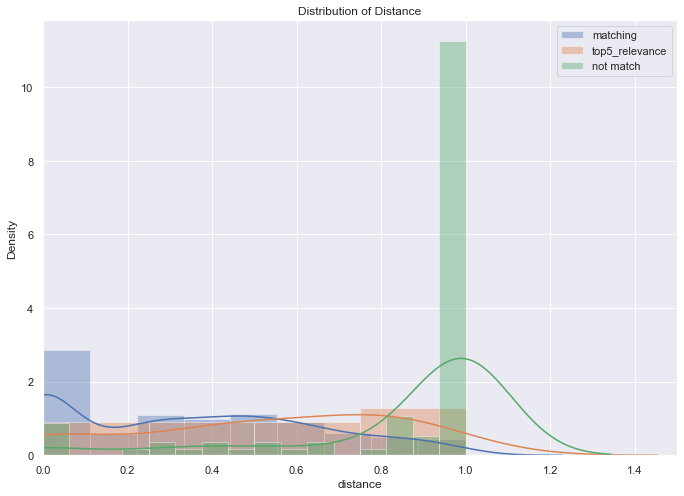

In [26]:
sb.set_theme()
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_match.distance, label = 'matching')
plt.subplot(121)
sb.distplot(df_top5.distance, label = 'top5_relevance')
plt.subplot(121)
sb.distplot(df_no.distance, label = "not match")
plt.xlim([0, 1.5])
plt.legend()
plt.title('Distribution of Distance')
plt.show()

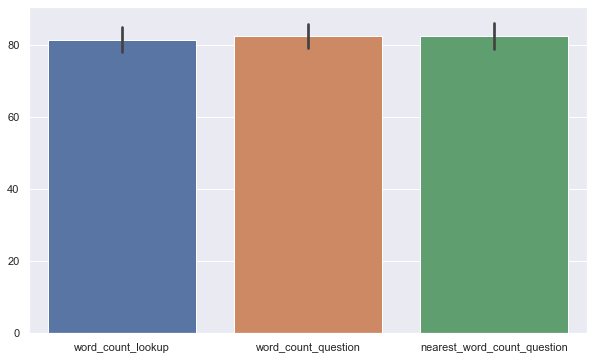

In [27]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_match[['word_count_lookup', 'word_count_question', 'nearest_word_count_question']]);

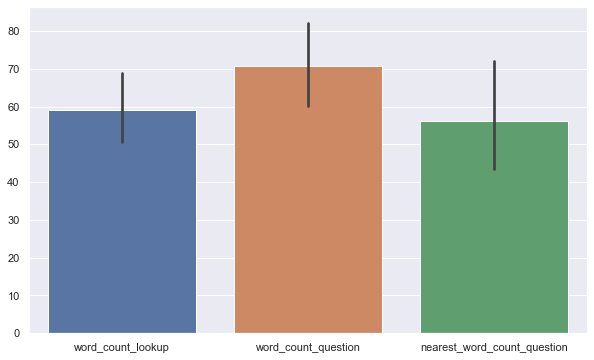

In [28]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_no[['word_count_lookup', 'word_count_question', 'nearest_word_count_question']]);

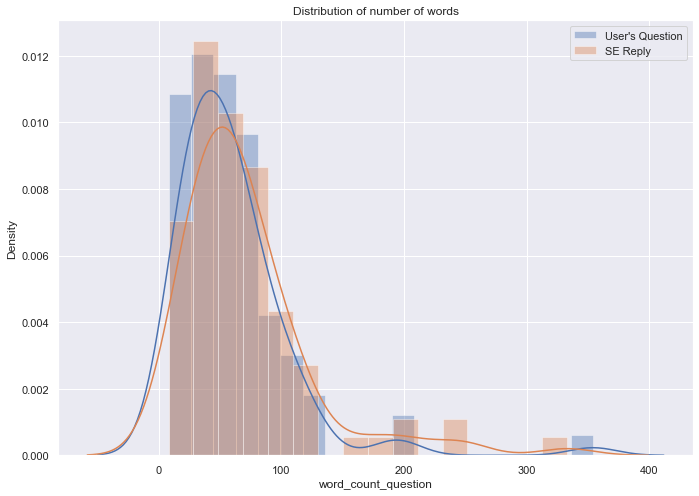

In [29]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_no.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_no.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

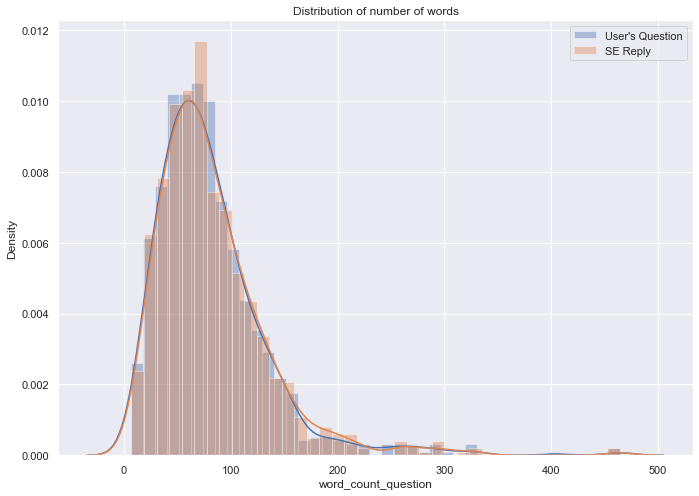

In [30]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_match.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_match.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

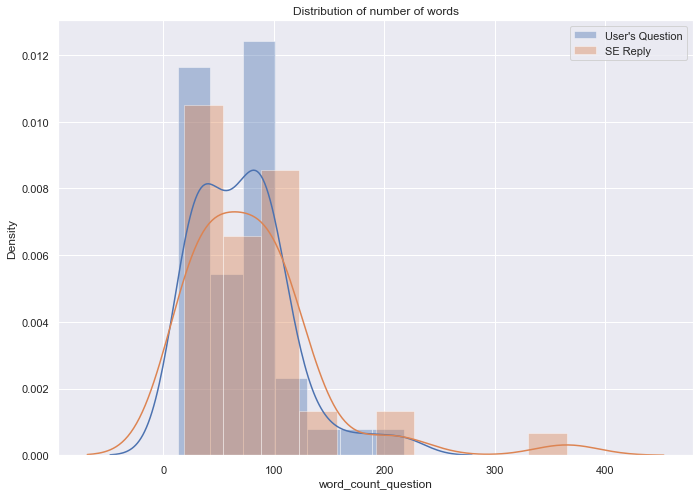

In [31]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_top5.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_top5.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()